In [830]:
import qutip
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from scipy.optimize import curve_fit
from scipy.linalg import expm
from sympy import *
init_printing()
#jtplot.style(theme='chesterish',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [1240]:
J=0.1*2*np.pi*2020
def strtransferstate(string):
    state=0
    for a in string:
        tmp=1-int(a)
        if state==0:
            state=qutip.basis(2,tmp)
        else:
            state=qutip.tensor(state,qutip.basis(2,tmp))
    return state

def allstates(n):
    a=[]
    if n==1:
        return ['1','0']
    else:
        for i in ['0','1']:
            a+=[i+o for o in allstates(n-1)]
        return a
    
def tsqtindtostate(n):
    strb=allstates(n)
    indexstate=[0]*len(strb)
    for i in range(len(strb)):
        state=strtransferstate(strb[i]).full()
        indexstate[np.argmax(state)]=strb[i]
    indexstate=np.array(indexstate)
    return indexstate
    
def splittosys(n):
    s = np.array(range(n))
    sets=set(s)
    coup1=[]
    coup2=[]
    for i in range(2**n):
        e = list(bin(i))[2:]
        e = np.array(e) == '1'
        tmp=s[n-len(e):][e]
        tmp=set(tmp)
        tmpb=sets-tmp
        if len(tmp)!=0 and len(tmp)!=n and (tmpb not in coup1):
            coup1.append(tmp)
            coup2.append(tmpb)
    return coup1,coup2

def entropycheck(state,oc):
    #s=(qutip.ket2dm(state)*qutip.ket2dm(state)).tr()
    t1=(state.ptrace(oc)*state.ptrace(oc)).tr()
    return t1
    
def genham(n,J):
    h1=-J*(qutip.tensor(qutip.sigmap(),qutip.sigmam())+qutip.tensor(qutip.sigmam(),qutip.sigmap()))-2*J*qutip.tensor(qutip.sigmaz(),qutip.sigmaz())
    hamodd=0
    hameven=0
    for i in range(n-1):
        if i==0:
            if n>2:
                s=[qutip.qeye(2)]*(n-2)
                hameven+=qutip.tensor(h1,qutip.tensor(*s))
            else:
                hameven+=h1
        elif i==n-2:
            s=[qutip.qeye(2)]*(n-2)
            hameven+=qutip.tensor(qutip.tensor(*s),h1)
        else:
            s1=[qutip.qeye(2)]*i
            s2=[qutip.qeye(2)]*(n-2-i)
            if i%2==0:
                hameven+=qutip.tensor(qutip.tensor(*s1),h1,qutip.tensor(*s2))
            else:
                hamodd+=qutip.tensor(qutip.tensor(*s1),h1,qutip.tensor(*s2))
    return hamodd,hameven
    #print(tmp)

def singleration(theta):
    rotationmatrix=np.array([(np.cos(theta/2),np.sin(theta/2)),(np.sin(theta/2),-np.cos(theta/2))])
    return qutip.Qobj(rotationmatrix)
    
def staterotation(n,singlerotation):
    allrataion=[singlerotation]*n
    wholerotate=qutip.tensor(*allrataion)
    return wholerotate

def totalspinoperator(n):
    s=qutip.sigmaz()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n-1)
        totalspin=qutip.tensor(s,*others)
        for i in range(1,n-1):
            others0=[tmp]*i
            others1=[tmp]*(n-i-1)
            totalspin+=qutip.tensor(*others0,s,*others1)
        totalspin+=qutip.tensor(*others,s)
        return totalspin
    
def totalspinyoperator(n):
    s=qutip.sigmay()
    tmp=qutip.qeye(2)
    if n==1:
        return s
    else:
        others=[tmp]*(n-1)
        totalspiny=qutip.tensor(s,*others)
        for i in range(1,n-1):
            others0=[tmp]*i
            others1=[tmp]*(n-i-1)
            totalspiny+=qutip.tensor(*others0,s,*others1)
        totalspiny+=qutip.tensor(*others,s)
        return totalspiny
        

In [1297]:
hamodd,hameven=genham(2,J)
initialstate=strtransferstate('10')
target=(-1j*strtransferstate('01')+strtransferstate('10')).unit()
times=np.linspace(0,2*np.pi/J,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
plt.figure(figsize=(14,8))
plt.plot(times,qutip.expect(qutip.ket2dm(initialstate),result1.states))
plt.plot(times,qutip.expect(qutip.ket2dm(target),result1.states))
#result1.states[int(15000/8)]

In [959]:
## basic ket
n=4
b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
b=list(set(b))
newb=[list(map(str,o)) for o in b]
strb=[''.join(o) for o in newb]
print(strb)
# statelist=[]
# statekettodmlist=[]
# for i in b:
#     tmp=qutip.basis(2,i[0])
#     for j in i[1:]:
#         tmp=qutip.tensor(tmp,qutip.basis(2,j))
#     statelist.append(tmp)
#     statekettodmlist.append(qutip.ket2dm(tmp))
#print(b)

['1010', '1100', '1001', '0110', '0101', '0011']


In [960]:
%%time
hamodd,hameven=genham(n,J)
initialstate=strtransferstate('1010')
#target=(strtransferstate('1010')-strtransferstate('0101')-1j*strtransferstate('1001')-1j*strtransferstate('0110')).unit()
times=np.linspace(0,2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states),c='b',label=r"initial state=$|\uparrow\downarrow\uparrow\downarrow>$")
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states),c='b')
#plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result1.states))
#plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result2.states))
plt.xlabel('$t*J$')
plt.legend(loc='best')

CPU times: user 7.13 s, sys: 376 ms, total: 7.5 s
Wall time: 9.11 s


[ 3  5  6  9 10 12]
['1100' '1010' '1001' '0110' '0101' '0011']


Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[-3.53567381e-01-1.11122048e-04j]
 [-4.97561287e-04+3.53567308e-01j]
 [ 4.99980319e-01+2.24379254e-07j]
 [ 4.99980319e-01+2.24379254e-07j]
 [-1.10569440e-04-3.53567198e-01j]
 [ 3.53566605e-01-4.97007748e-04j]]

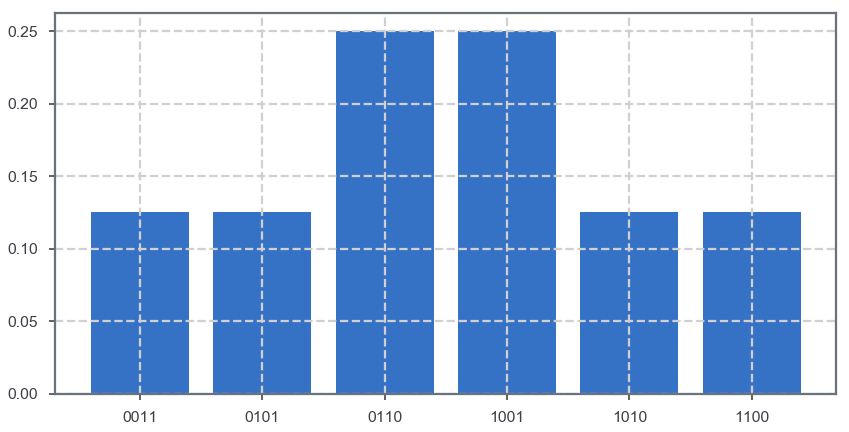

In [1144]:
## for n=4 case
n=4
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
finalstatevector=result2.states[-1].full().reshape((1,-1))
reducespacestate=qutip.Qobj(finalstatevector[finalstatevector!=0])
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(14,7))
plt.bar(indic[location[0]],s[location])
reducespacestate

CPU times: user 3.57 s, sys: 91.9 ms, total: 3.66 s
Wall time: 4.45 s


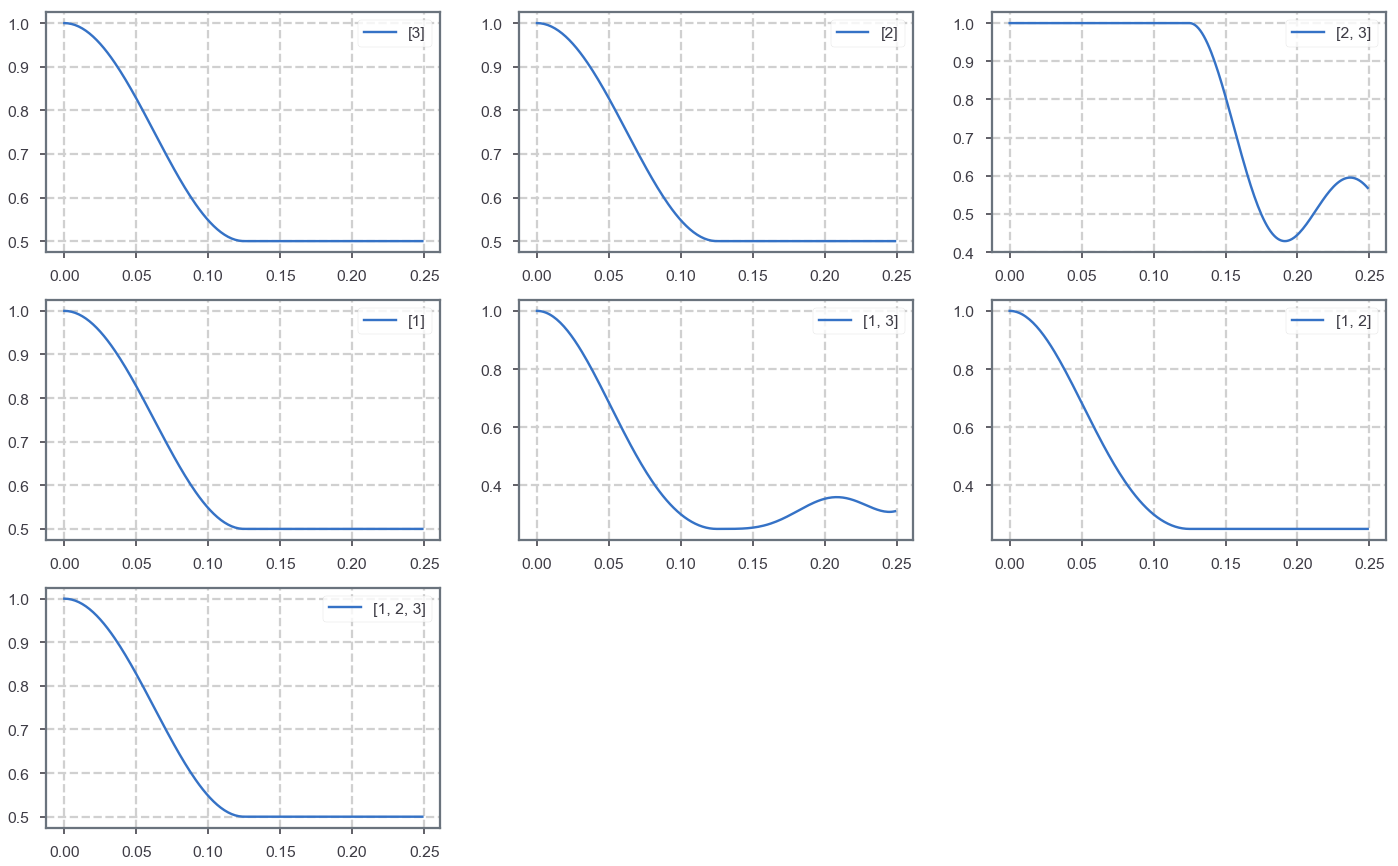

In [962]:
%%time
allpos=splittosys(4)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/100)*np.arange(100)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(24,15))
j=1
for i in allpos:
    i=list(i)
    rho1=np.array([entropycheck(state,i) for state in statesin])
    plt.subplot(3,3,j)
    plt.plot(t2*J/2/np.pi,rho1,label=str(i))
    plt.legend(loc='best')
    j+=1

All possible remain atoms config: [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
Not entangled pair: [([2, 3], [1])]
Not entangled pair: [([2, 3], [0])]
Not entangled pair: [([3], [0, 1])]
Not entangled pair: [([2], [0, 1])]


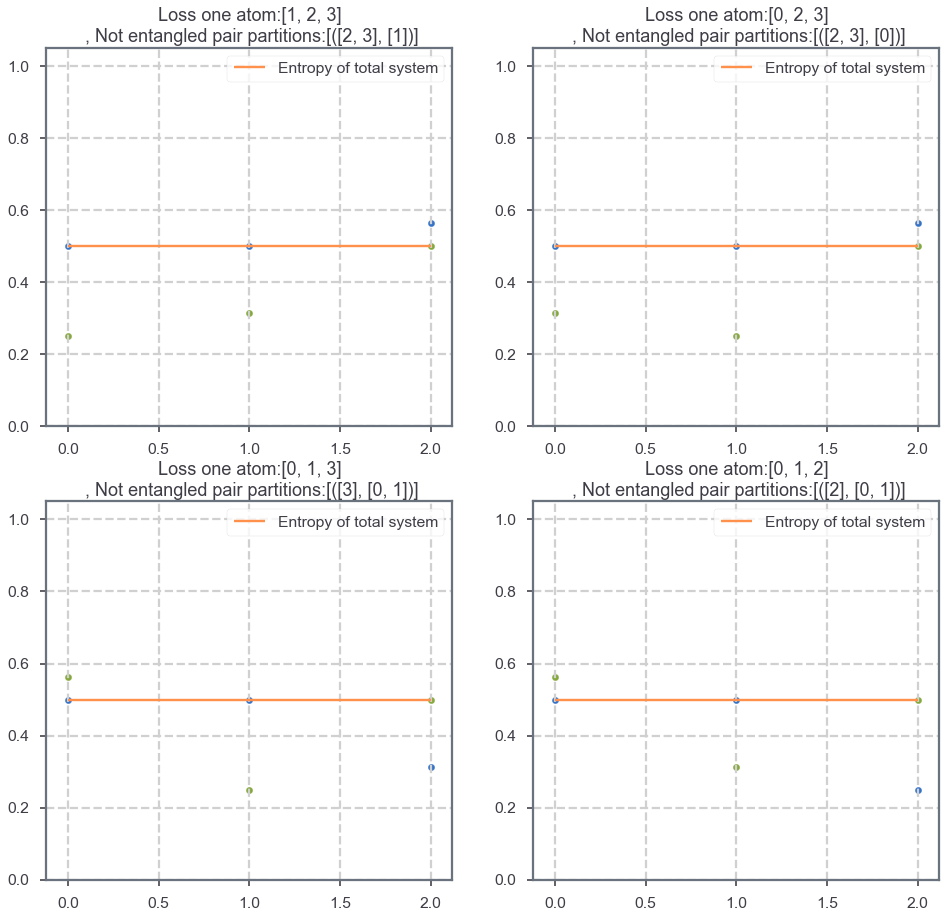

In [963]:
lossconfig=[]
for i in range(n):
    tmp=list(range(n))
    del (tmp[i])
    lossconfig.append(tmp)

print('All possible remain atoms config:',lossconfig)
allposloss0=splittosys(n-1)[0]
allposloss1=splittosys(n-1)[1]

finalstate=np.array(result2.states)[-1]
pltflag=1
plt.figure(figsize=(16,4*8))
for config in lossconfig: 
    finalentrpy0=[]
    finalentrpy1=[]
    lossstate=finalstate.ptrace(config)
    entropytotal=round(entropycheck(finalstate,config),5)
    unentangledpair=[]
    for i in range(len(allposloss0)):
        s0=list(allposloss0[i])
        s1=list(allposloss1[i])
        subentropy0=round(entropycheck(lossstate,s0),5)
        subentropy1=round(entropycheck(lossstate,s1),5)
        finalentrpy0.append(subentropy0)
        finalentrpy1.append(subentropy1)
        if subentropy0>entropytotal or subentropy1>entropytotal:
            #print(subentropy0,subentropy1)
            unentangledpair.append((list(np.array(config)[s0]),list(np.array(config)[s1])))
    plt.subplot(4,2,pltflag)
    pltflag+=1
    #plt.title('Purity of Subsystem')
    plt.ylim((0,1.05))
    plt.title('Loss one atom:'+str(config)+'\n , Not entangled pair partitions:'+str(unentangledpair))
    plt.hlines(entropytotal,0,len(allposloss0)-1,colors='y',label='Entropy of total system')
    plt.scatter(range(len(allposloss0)),finalentrpy0,s=40)
    plt.scatter(range(len(allposloss1)),finalentrpy1,s=40)
    plt.legend(loc='best')
    #print([np.array(config)[list(i)] for i in allposloss0])
    print('Not entangled pair:',unentangledpair)

## 1. Non-Local Bell Inequlity Verification

Symmetric Bell inequality from J. Tura et al., Science 344, 1256–1258 (2014).

$$\alpha S_0+\beta S_1+ \gamma S_{00}/2+\sigma S_{01}+\varepsilon S_{11}/2+\beta_{c} \ge 0$$

However our final state can't violate the inequlity in this paper, since our state is not a symmetric state and symmetric states have the largest violation.

In [1300]:
def calviolationofbell(state,theta0,theta1):
    spintotal=totalspinoperator(n)
    spinspincorrelation=spintotal*spintotal
    m0=singleration(theta0)
    m0total=staterotation(n,m0)
    m1=singleration(theta1)
    m1total=staterotation(n,m1)
    m1timesm0=np.cos(theta0-theta1)
    absm0mlusm1=np.sqrt(2-2*m1timesm0)
    m0mlusm1=singleration((theta1+theta0)/2+np.pi/2)
    m0mlusm1total=staterotation(n,m0mlusm1)
    absm0plusm1=np.sqrt(2+2*m1timesm0)
    m0plusm1=singleration((theta1+theta0)/2)
    m0plusm1total=staterotation(n,m0plusm1)

    s0=qutip.expect(spintotal,m0total*statecheck)
    s1=qutip.expect(spintotal,m1total*statecheck)
    s11=qutip.expect(spinspincorrelation,m1total*statecheck)-n
    s00=qutip.expect(spinspincorrelation,m0total*statecheck)-n
    s01=0.25*((absm0plusm1)**2*qutip.expect(spinspincorrelation,m0plusm1total*statecheck)-(absm0mlusm1)**2*qutip.expect(spinspincorrelation,m0mlusm1total*statecheck))-n*m1timesm0

    alpha=n*(n-1)*(np.ceil(n/2)-n/2)
    beta=alpha/n
    gama=n*(n-1)/2
    sigma=n/2
    ebxl=-1
    betac=0.5*n*(n-1)*np.ceil((n+2)/2)

#     alpha=2
#     beta=0
#     gama=1
#     sigma=1
#     ebxl=1
#     betac=2*n

    #     alpha=0
    #     beta=0
    #     gama=0
    #     sigma=0
    #     ebxl=-1
    #     betac=12

    #betac,alpha,beta,gama,sigma,ebxl=12,3,3,0,1,0


    belleq=alpha*s0+beta*s1+gama*s00/2+sigma*s01+ebxl*s11/2+betac
    return belleq

dickestate=(qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1))).unit()

statecheck=dickestate
theta0list=np.linspace(0,1,30)*np.pi
theta1list=np.linspace(0,1,30)*np.pi
total = len(theta0list)*len(theta1list)
bellall=[]

for theta0 in theta0list:
    for theta1 in theta1list:
        bellall.append(calviolationofbell(statecheck,theta0,theta1))

bellall = np.array(bellall)
bellall = bellall.reshape((len(theta0list),len(theta1list)))

-0.6644362679129188


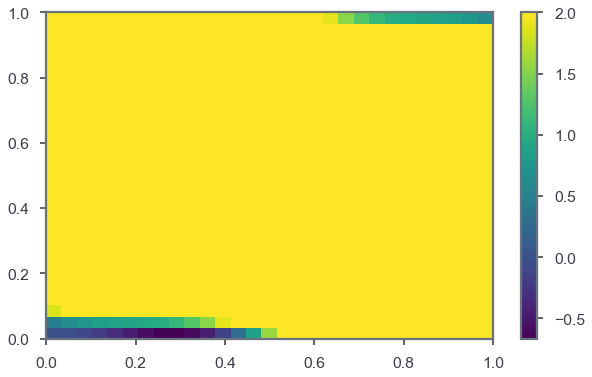

In [1304]:
print(np.min(bellall))
plt.figure(figsize=(10,6))
#plt.ylim((-0.038,0))
plt.pcolor(theta0list/(np.pi),theta1list/(np.pi),bellall,vmax=2)
#plt.plot(np.linspace(0,0.4*np.pi,50)/np.pi,bell)
plt.colorbar()

## 2. squeezing parameter

According to the paper A. Sørensen, L.-M. Duan, J. I. Cirac, and P. Zoller , Nature (London) 409, 63 (2001), we can define a squeezing parameter:
$$\xi^{2}=\frac{N(\Delta J_{z})^2}{<J_{x}>^2+<J_{y}>^2}$$

if $\xi^2<1$, this state is spin squeezed, and it is also entangled.

In [1281]:
def calsqueez(state):
    spintotal=totalspinoperator(n)
    spintotaly=totalspinyoperator(n)
    spinspincorrelation=spintotal*spintotal
    spinspinycorrelation=spintotaly*spintotaly
    mx=singleration(np.pi/2)
    mxtotal=staterotation(n,mx)
    my=qutip.Qobj(0.5**0.5*np.array([(1,-1j),(-1,-1j)]))
    mytotal=staterotation(n,my)
    averagex=qutip.expect(spintotal,mxtotal*state)
    averagey=qutip.expect(spintotaly,state)
    averagez=qutip.expect(spintotal,state)
    averagexsq=qutip.expect(spinspincorrelation,mxtotal*state)
    averageysq=qutip.expect(spinspinycorrelation,state)
    averagezsq=qutip.expect(spinspincorrelation,state)
    variancex=averagexsq-averagex**2
    variancey=averageysq-averagey**2
    variancez=averagezsq-averagez**2
    print(averagex)
    print(averagey)
    print(variancez)
    return averagexsq+averageysq+averagezsq,variancex+variancey+variancez-2*n,(n-1)*variancez+2*n-averageysq-averagexsq#n*variancez/(n**2-averagez**2)


dickestate0=(qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,0),qutip.basis(2,1))).unit()

dickestate1=(qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0))
                +qutip.tensor(qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1),qutip.basis(2,1))
                +qutip.tensor(qutip.basis(2,1),qutip.basis(2,1),qutip.basis(2,0),qutip.basis(2,1))).unit()

calsqueez(dickestate0)

8.881784197001252e-16
0.0
0.0


CPU times: user 8.26 s, sys: 884 ms, total: 9.15 s
Wall time: 13 s


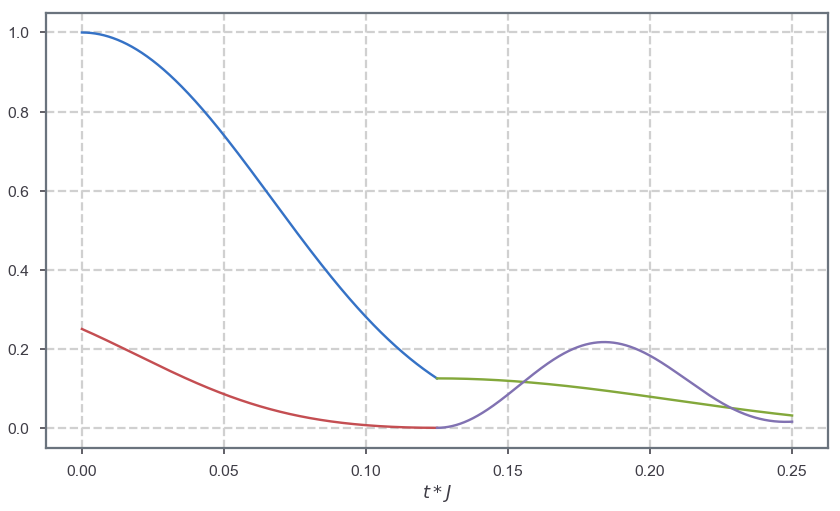

In [1305]:
%%time
hamodd,hameven=genham(6,J)
initialstate=strtransferstate('101010')
target=(strtransferstate('101010')-strtransferstate('010101')-1j*strtransferstate('100110')-1j*strtransferstate('011001')).unit()
times=np.linspace(0,2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.xlabel('$t*J$')
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states))
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states))
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result1.states))
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(target),result2.states))

In [1306]:
## for n=6 case
n=6
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
#print(s)
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(14,7))
plt.barh(indic[location[0]],s[location])

[11 13 14 19 21 22 25 26 28 35 37 38 41 42 44 49 50 52]
['110100' '110010' '110001' '101100' '101010' '101001' '100110' '100101'
 '100011' '011100' '011010' '011001' '010110' '010101' '010011' '001110'
 '001101' '001011']


<Container object of 18 artists>

0.5
0.5
0.568
0.5
0.311
0.25
0.5
0.5
0.25
0.266
0.386
0.395
0.291
0.284
0.568
0.5
0.25
0.265
0.291
0.266
0.193
0.155
0.311
0.25
0.125
0.155
0.25
0.284
0.25
0.25
0.5
CPU times: user 2.43 s, sys: 60.5 ms, total: 2.49 s
Wall time: 2.98 s


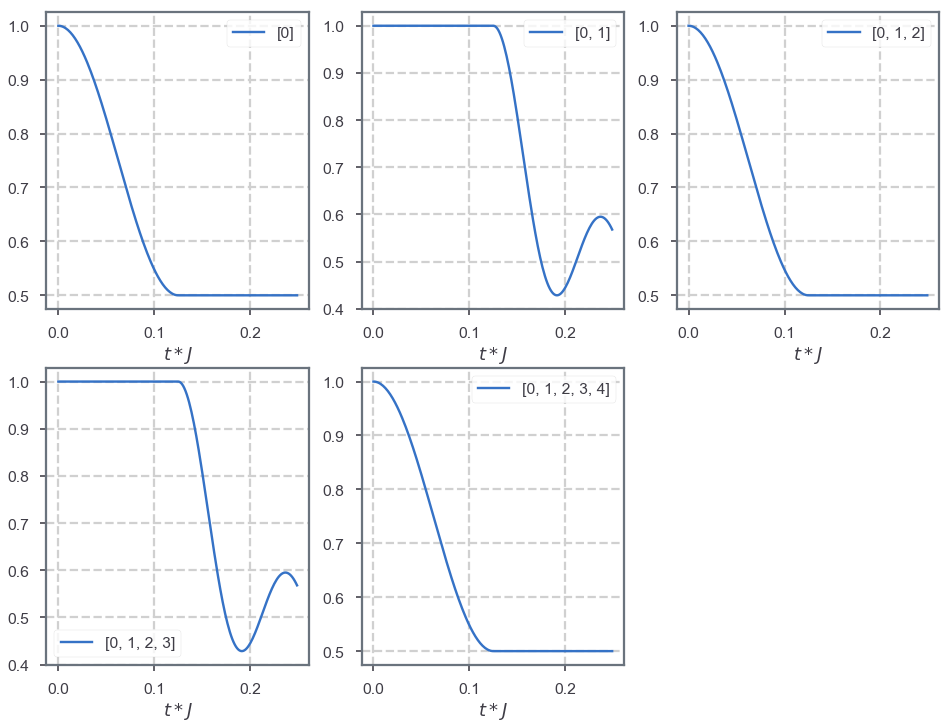

In [1308]:
%%time
allpos=splittosys(6)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/100)*np.arange(100)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(16,12))
for i in range(1,6):
#     length=len(i)
# #     print()
#     st1=set(list(range(length)))
#     st2=set(list(range(6)))-st1
#     if i==st1 or i==st2:
        #print(i)
    sd=list(range(i))
    rho1=np.array([entropycheck(state,sd) for state in statesin])
    plt.subplot(2,3,i)
    plt.xlabel('$t*J$')
    plt.plot(t2*J/2/np.pi,rho1,label=str(sd))
    plt.legend(loc='best')
    
finalstate=statesin[-1]
finalentrpy=[]
for i in allpos:
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Purity of Subsystem')
plt.ylim((0,1))
plt.scatter(range(len(allpos)),finalentrpy,s=40)
for y in finalentrpy:
    print(round(y,3))

In [930]:
lossconfig=[]
for i in range(n):
    tmp=list(range(n))
    del (tmp[i])
    lossconfig.append(tmp)

print('All possible remain atoms config:',lossconfig)
allposloss0=splittosys(n-1)[0]
allposloss1=splittosys(n-1)[1]

finalstate=np.array(result2.states)[-1]
pltflag=1
plt.figure(figsize=(16,4*8))
for config in lossconfig: 
    finalentrpy0=[]
    finalentrpy1=[]
    lossstate=finalstate.ptrace(config)
    entropytotal=round(entropycheck(finalstate,config),5)
    unentangledpair=[]
    for i in range(len(allposloss0)):
        s0=list(allposloss0[i])
        s1=list(allposloss1[i])
        subentropy0=round(entropycheck(lossstate,s0),5)
        subentropy1=round(entropycheck(lossstate,s1),5)
        finalentrpy0.append(subentropy0)
        finalentrpy1.append(subentropy1)
        if subentropy0>entropytotal or subentropy1>entropytotal:
            #print(subentropy0,subentropy1)
            unentangledpair.append((list(np.array(config)[s0]),list(np.array(config)[s1])))
    plt.subplot(4,2,pltflag)
    pltflag+=1
    #plt.title('Purity of Subsystem')
    plt.ylim((0,1.05))
    plt.title('Loss one atom:'+str(config)+'\n , Not entangled pair partitions:'+str(unentangledpair))
    plt.hlines(entropytotal,0,len(allposloss0)-1,colors='y',label='Entropy of total system')
    plt.scatter(range(len(allposloss0)),finalentrpy0,s=40)
    plt.scatter(range(len(allposloss1)),finalentrpy1,s=40)
    plt.legend(loc='best')
    print([np.array(config)[list(i)] for i in allposloss0])
    print('Not entangled pair:',unentangledpair)

All possible remain atoms config: [[1, 2, 3, 4, 5], [0, 2, 3, 4, 5], [0, 1, 3, 4, 5], [0, 1, 2, 4, 5], [0, 1, 2, 3, 5], [0, 1, 2, 3, 4]]
[array([5]), array([4]), array([4, 5]), array([3]), array([3, 5]), array([3, 4]), array([3, 4, 5]), array([2]), array([2, 5]), array([2, 4]), array([2, 4, 5]), array([2, 3]), array([2, 3, 5]), array([2, 3, 4]), array([2, 3, 4, 5])]
Not entangled pair: [([4, 5], [1, 2, 3]), ([2, 3, 4, 5], [1])]
[array([5]), array([4]), array([4, 5]), array([3]), array([3, 5]), array([3, 4]), array([3, 4, 5]), array([2]), array([2, 5]), array([2, 4]), array([2, 4, 5]), array([2, 3]), array([2, 3, 5]), array([2, 3, 4]), array([2, 3, 4, 5])]
Not entangled pair: [([4, 5], [0, 2, 3]), ([2, 3, 4, 5], [0])]
[array([5]), array([4]), array([4, 5]), array([3]), array([3, 5]), array([3, 4]), array([3, 4, 5]), array([1]), array([1, 5]), array([1, 4]), array([1, 4, 5]), array([1, 3]), array([1, 3, 5]), array([1, 3, 4]), array([1, 3, 4, 5])]
Not entangled pair: [([4, 5], [0, 1, 3]),

CPU times: user 8.96 s, sys: 684 ms, total: 9.64 s
Wall time: 12.3 s


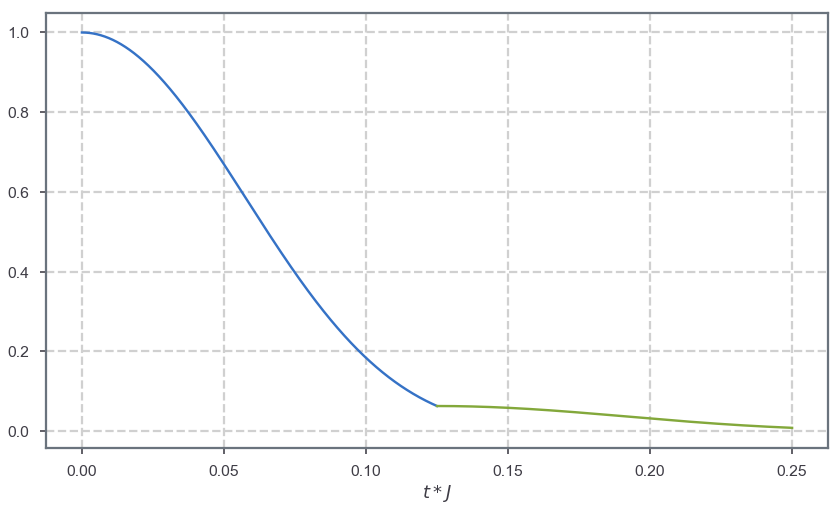

In [931]:
%%time
hamodd,hameven=genham(8,J)
initialstate=strtransferstate('10101010')
#target=(strtransferstate('10101010')-strtransferstate('010101')-1j*strtransferstate('100110')-1j*strtransferstate('011001')).unit()
times=np.linspace(0,2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.xlabel('$t*J$')
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states))
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states))
# plt.plot(times,qutip.expect(qutip.ket2dm(target),result1.states))
# plt.plot(times+times[-1],qutip.expect(qutip.ket2dm(target),result2.states))

[ 43  45  46  51  53  54  57  58  60  75  77  78  83  85  86  89  90  92
  99 101 102 105 106 108 113 114 116 139 141 142 147 149 150 153 154 156
 163 165 166 169 170 172 177 178 180 195 197 198 201 202 204 209 210 212]
['11010100' '11010010' '11010001' '11001100' '11001010' '11001001'
 '11000110' '11000101' '11000011' '10110100' '10110010' '10110001'
 '10101100' '10101010' '10101001' '10100110' '10100101' '10100011'
 '10011100' '10011010' '10011001' '10010110' '10010101' '10010011'
 '10001110' '10001101' '10001011' '01110100' '01110010' '01110001'
 '01101100' '01101010' '01101001' '01100110' '01100101' '01100011'
 '01011100' '01011010' '01011001' '01010110' '01010101' '01010011'
 '01001110' '01001101' '01001011' '00111100' '00111010' '00111001'
 '00110110' '00110101' '00110011' '00101110' '00101101' '00101011']


<Container object of 54 artists>

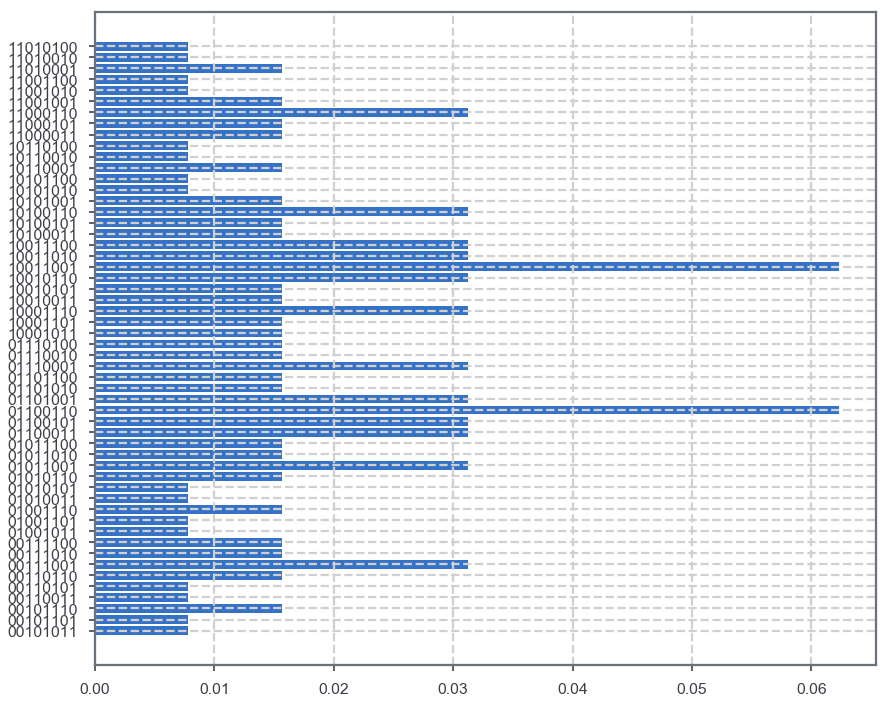

In [932]:
## for n=8 case
n=8
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
#print(s)
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(14,12))
plt.barh(indic[location[0]],s[location])

In [933]:
%%time
allpos=splittosys(8)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/100)*np.arange(100)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(16,18))
for i in range(1,8):
#     length=len(i)
# #     print()
#     st1=set(list(range(length)))
#     st2=set(list(range(6)))-st1
#     if i==st1 or i==st2:
        #print(i)
    sd=list(range(i))
    rho1=np.array([entropycheck(state,sd) for state in statesin])
    plt.subplot(3,3,i)
    plt.xlabel('$t*J$')
    plt.plot(t2*J/2/np.pi,rho1,label=str(sd))
    plt.legend(loc='best')
    
finalstate=statesin[-1]
finalentrpy=[]
for i in allpos:
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Purity of Subsystem')
plt.ylim((0,1))
plt.scatter(range(len(allpos)),finalentrpy,s=40)

CPU times: user 6.48 s, sys: 174 ms, total: 6.66 s
Wall time: 9.72 s


All possible remain atoms config: [[1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8]]
Not entangled pair: [([9, 8], [1, 2, 3, 4, 5, 6, 7]), ([9, 6, 7, 8], [1, 2, 3, 4, 5]), ([4, 5, 6, 7, 8, 9], [1, 2, 3]), ([2, 3, 4, 5, 6, 7, 8, 9], [1])] 
 ---------------------------------------------
Not entangled pair: [([9, 8], [0, 2, 3, 4, 5, 6, 7]), ([9, 6, 7, 8], [0, 2, 3, 4, 5]), ([4, 5, 6, 7, 8, 9], [0, 2, 3]), ([2, 3, 4, 5, 6, 7, 8, 9], [0])] 
 ---------------------------------------------
Not entangled pair: [([9, 8], [0, 1, 3, 4, 5, 6, 7]), ([9, 6, 7, 8], [0, 1, 3, 4, 5]), ([4, 5, 6, 7, 8, 9], [0, 1, 3]), ([3, 4, 5, 6, 7, 8, 9], [0, 1])] 
 ---------------------------------------------
Not entangled pair: [([9, 8], [0, 1, 2, 4, 5, 6, 7]), ([9, 6, 7, 8], [0,

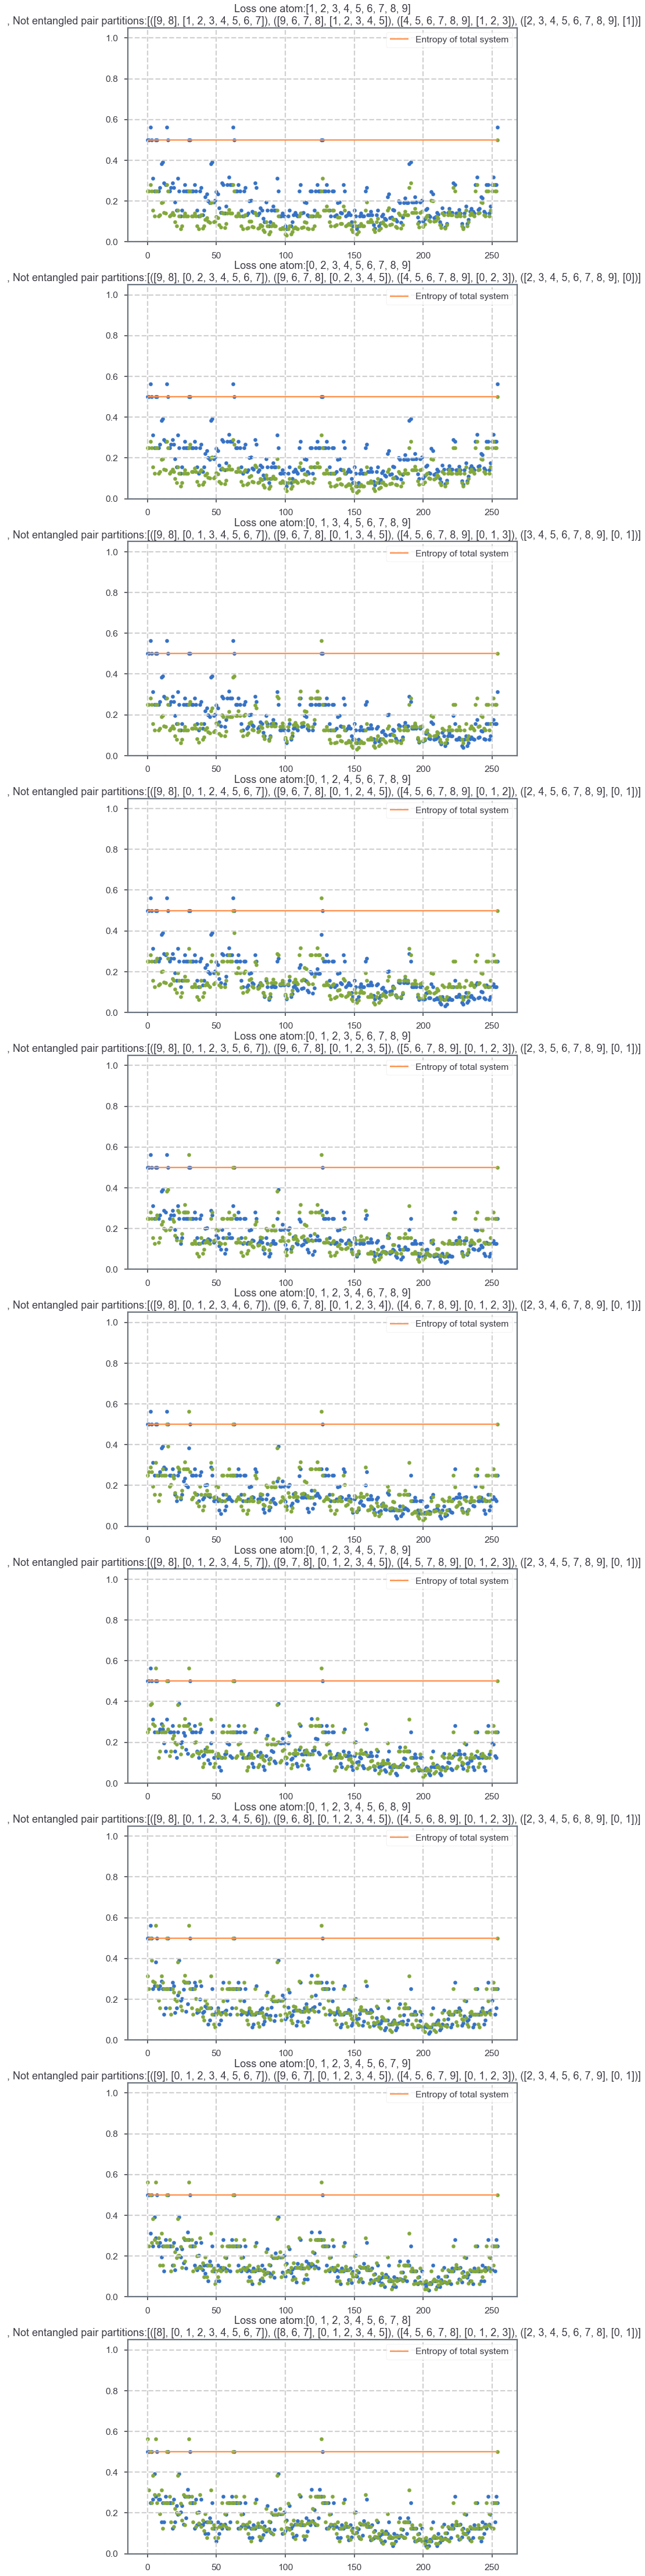

In [958]:
lossconfig=[]
for i in range(n):
    tmp=list(range(n))
    del (tmp[i])
    lossconfig.append(tmp)

print('All possible remain atoms config:',lossconfig)
allposloss0=splittosys(n-1)[0]
allposloss1=splittosys(n-1)[1]

finalstate=np.array(result2.states)[-1]
pltflag=1
plt.figure(figsize=(12,8*10))
for config in lossconfig: 
    finalentrpy0=[]
    finalentrpy1=[]
    lossstate=finalstate.ptrace(config)
    entropytotal=round(entropycheck(finalstate,config),5)
    unentangledpair=[]
    for i in range(len(allposloss0)):
        s0=list(allposloss0[i])
        s1=list(allposloss1[i])
        subentropy0=round(entropycheck(lossstate,s0),5)
        subentropy1=round(entropycheck(lossstate,s1),5)
        finalentrpy0.append(subentropy0)
        finalentrpy1.append(subentropy1)
        if subentropy0>entropytotal or subentropy1>entropytotal:
            #print(subentropy0,subentropy1)
            unentangledpair.append((list(np.array(config)[s0]),list(np.array(config)[s1])))
    plt.subplot(10,1,pltflag)
    pltflag+=1
    #plt.title('Purity of Subsystem')
    plt.ylim((0,1.05))
    plt.title('Loss one atom:'+str(config)+'\n , Not entangled pair partitions:'+str(unentangledpair))
    plt.hlines(entropytotal,0,len(allposloss0)-1,colors='y',label='Entropy of total system')
    plt.scatter(range(len(allposloss0)),finalentrpy0,s=40)
    plt.scatter(range(len(allposloss1)),finalentrpy1,s=40)
    plt.legend(loc='best')
    #print([np.array(config)[list(i)] for i in allposloss0])
    print('Not entangled pair:',unentangledpair,'\n ---------------------------------------------')

## For 10 bits spin chain

CPU times: user 14.9 s, sys: 2 s, total: 16.9 s
Wall time: 23.2 s


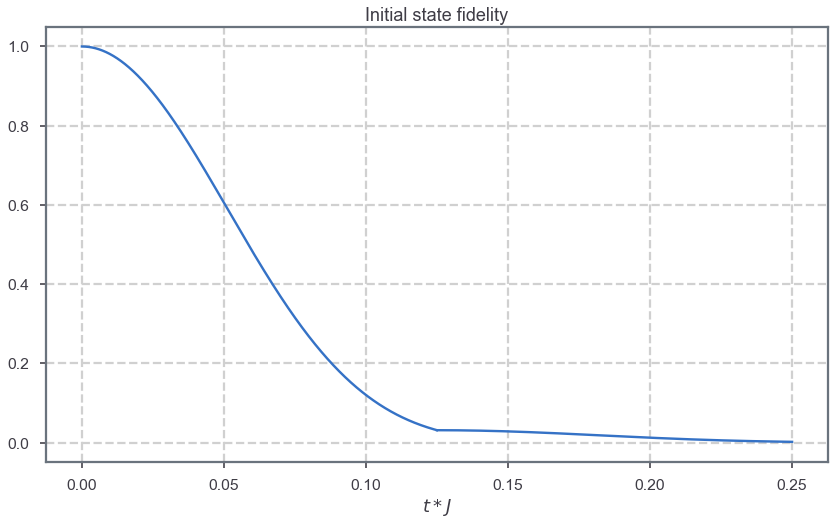

In [935]:
%%time
hamodd,hameven=genham(10,J)
initialstate=strtransferstate('1010101010')
#target=(strtransferstate('10101010')-strtransferstate('010101')-1j*strtransferstate('100110')-1j*strtransferstate('011001')).unit()
times=np.linspace(0,1*2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.title('Initial state fidelity')
plt.xlabel('$t*J$')
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states),c='b',label=r"initial state=$|\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow>$")
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states),c='b')
# plt.plot(times,qutip.expect(qutip.ket2dm(target),result1.states))
# plt.plot(times+times[-1],qutip.expect(qutip.ket2dm(target),result2.states))

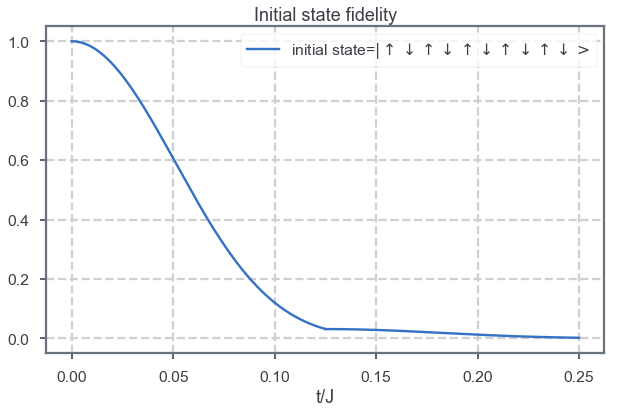

In [936]:
plt.figure(figsize=(10,6))
plt.plot((times)*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states),c='b',label=r"initial state=$|\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow\uparrow\downarrow>$")
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states))
plt.title('Initial state fidelity')
plt.xlabel('t/J')
plt.legend(loc='best')
plt.savefig('initialstatefidelityfor10bits.pdf')

[171 173 174 179 181 182 185 186 188 203 205 206 211 213 214 217 218 220
 227 229 230 233 234 236 241 242 244 299 301 302 307 309 310 313 314 316
 331 333 334 339 341 342 345 346 348 355 357 358 361 362 364 369 370 372
 395 397 398 403 405 406 409 410 412 419 421 422 425 426 428 433 434 436
 451 453 454 457 458 460 465 466 468 555 557 558 563 565 566 569 570 572
 587 589 590 595 597 598 601 602 604 611 613 614 617 618 620 625 626 628
 651 653 654 659 661 662 665 666 668 675 677 678 681 682 684 689 690 692
 707 709 710 713 714 716 721 722 724 779 781 782 787 789 790 793 794 796
 803 805 806 809 810 812 817 818 820 835 837 838 841 842 844 849 850 852]
['1101010100' '1101010010' '1101010001' '1101001100' '1101001010'
 '1101001001' '1101000110' '1101000101' '1101000011' '1100110100'
 '1100110010' '1100110001' '1100101100' '1100101010' '1100101001'
 '1100100110' '1100100101' '1100100011' '1100011100' '1100011010'
 '1100011001' '1100010110' '1100010101' '1100010011' '1100001110'
 '1100001101

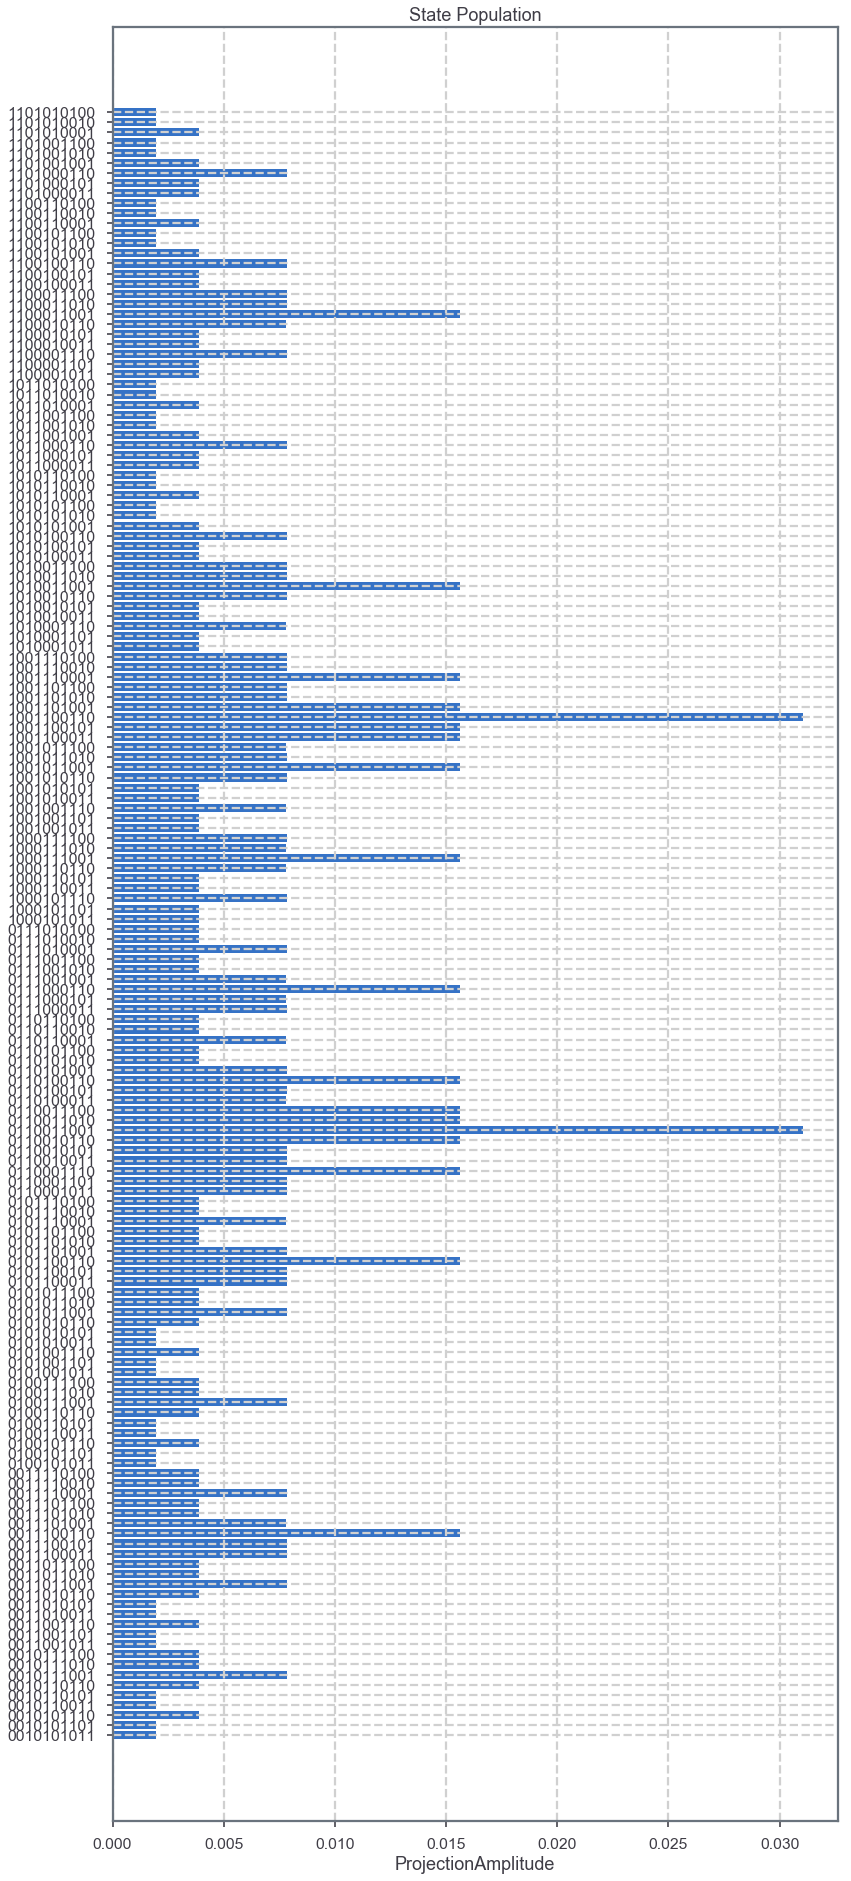

In [937]:
## for n=10 case
n=10
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
#print(s)
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(13,33))
plt.xlabel('ProjectionAmplitude')
plt.title('State Population')
#plt.yticks(rotation=45)
#plt.tight_layout()
plt.barh(indic[location[0]],s[location])
plt.savefig('StatePopulation.pdf')

CPU times: user 1min 56s, sys: 12.4 s, total: 2min 8s
Wall time: 2min 19s


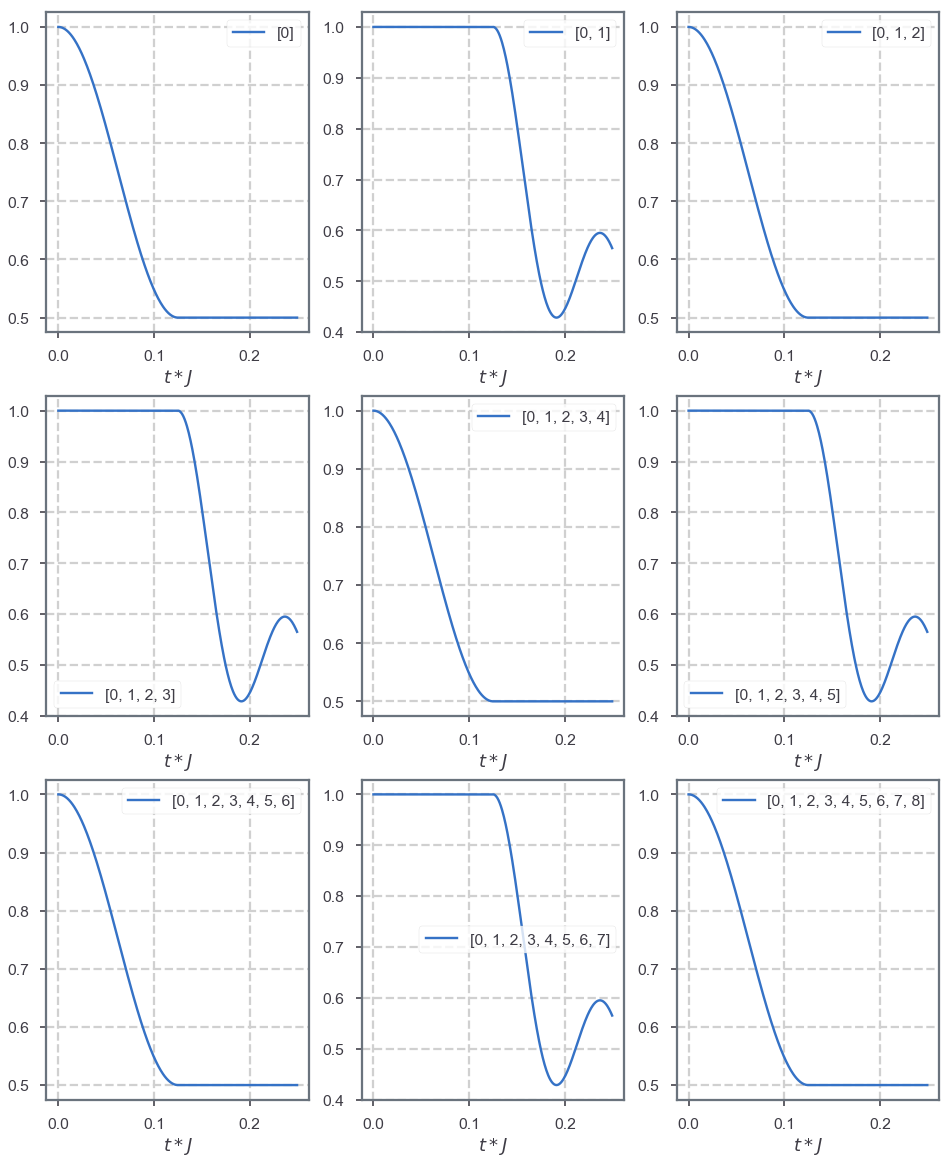

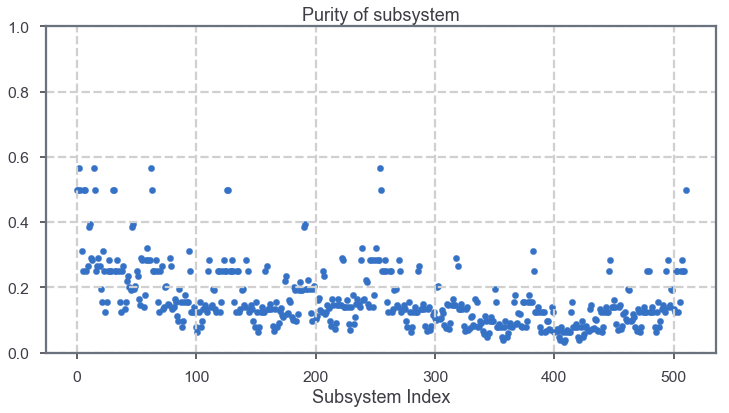

In [655]:
%%time
allpos=splittosys(10)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/200)*np.arange(200)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(16,20))
plt.title('1-Subsystem Purity')

for i in range(1,10):
#     length=len(i)
# #     print()
#     st1=set(list(range(length)))
#     st2=set(list(range(6)))-st1
#     if i==st1 or i==st2:
        #print(i)
    sd=list(range(i))
    rho1=np.array([entropycheck(state,sd) for state in statesin])
    plt.subplot(3,3,i)
    plt.xlabel('$t*J$')
    plt.plot(t2*J/2/np.pi,rho1,label=str(sd))
    plt.legend(loc='best')
#plt.savefig('Evolution of Subsystem Entropy.pdf')
    
finalstate=statesin[-1]
finalentrpy=[]
for i in allpos:
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Purity of subsystem')
plt.ylim((0,1))
plt.xlabel('Subsystem Index')
plt.scatter(range(len(allpos)),finalentrpy,s=40)
#plt.savefig('Subsystem Entropy.pdf')

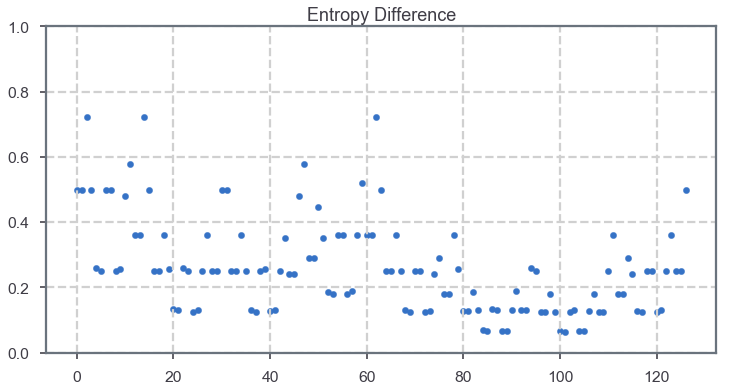

In [654]:
finalstate=statesin[125]
finalentrpy=[]
for i in allpos:
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Entropy Difference')
plt.ylim((0,1))
plt.scatter(range(len(allpos)),finalentrpy,s=40)

All possible remain atoms config: [[1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8]]
[array([9]), array([8]), array([9, 8]), array([7]), array([9, 7]), array([7, 8]), array([9, 7, 8]), array([6]), array([9, 6]), array([6, 8]), array([9, 6, 8]), array([6, 7]), array([9, 6, 7]), array([6, 7, 8]), array([9, 6, 7, 8]), array([5]), array([9, 5]), array([5, 8]), array([9, 5, 8]), array([5, 7]), array([9, 5, 7]), array([5, 7, 8]), array([9, 5, 7, 8]), array([5, 6]), array([9, 5, 6]), array([5, 6, 8]), array([9, 5, 6, 8]), array([5, 6, 7]), array([9, 5, 6, 7]), array([5, 6, 7, 8]), array([5, 6, 7, 8, 9]), array([4]), array([9, 4]), array([4, 8]), array([9, 4, 8]), array([4, 7]), array([9, 4, 7]), array([4, 7, 8]), array([9, 4, 7, 8]), array([4, 6]), array([9

[array([9]), array([8]), array([9, 8]), array([7]), array([9, 7]), array([7, 8]), array([9, 7, 8]), array([6]), array([9, 6]), array([6, 8]), array([9, 6, 8]), array([6, 7]), array([9, 6, 7]), array([6, 7, 8]), array([9, 6, 7, 8]), array([5]), array([9, 5]), array([5, 8]), array([9, 5, 8]), array([5, 7]), array([9, 5, 7]), array([5, 7, 8]), array([9, 5, 7, 8]), array([5, 6]), array([9, 5, 6]), array([5, 6, 8]), array([9, 5, 6, 8]), array([5, 6, 7]), array([9, 5, 6, 7]), array([5, 6, 7, 8]), array([5, 6, 7, 8, 9]), array([4]), array([9, 4]), array([4, 8]), array([9, 4, 8]), array([4, 7]), array([9, 4, 7]), array([4, 7, 8]), array([9, 4, 7, 8]), array([4, 6]), array([9, 4, 6]), array([4, 6, 8]), array([9, 4, 6, 8]), array([4, 6, 7]), array([9, 4, 6, 7]), array([4, 6, 7, 8]), array([4, 6, 7, 8, 9]), array([4, 5]), array([9, 4, 5]), array([4, 5, 8]), array([9, 4, 5, 8]), array([4, 5, 7]), array([9, 4, 5, 7]), array([4, 5, 7, 8]), array([4, 5, 7, 8, 9]), array([4, 5, 6]), array([9, 4, 5, 6]

[array([9]), array([8]), array([9, 8]), array([7]), array([9, 7]), array([7, 8]), array([9, 7, 8]), array([6]), array([9, 6]), array([6, 8]), array([9, 6, 8]), array([6, 7]), array([9, 6, 7]), array([6, 7, 8]), array([9, 6, 7, 8]), array([5]), array([9, 5]), array([5, 8]), array([9, 5, 8]), array([5, 7]), array([9, 5, 7]), array([5, 7, 8]), array([9, 5, 7, 8]), array([5, 6]), array([9, 5, 6]), array([5, 6, 8]), array([9, 5, 6, 8]), array([5, 6, 7]), array([9, 5, 6, 7]), array([5, 6, 7, 8]), array([5, 6, 7, 8, 9]), array([3]), array([9, 3]), array([3, 8]), array([9, 3, 8]), array([3, 7]), array([9, 3, 7]), array([3, 7, 8]), array([9, 3, 7, 8]), array([3, 6]), array([9, 3, 6]), array([3, 6, 8]), array([9, 3, 6, 8]), array([3, 6, 7]), array([9, 3, 6, 7]), array([3, 6, 7, 8]), array([3, 6, 7, 8, 9]), array([3, 5]), array([9, 3, 5]), array([3, 5, 8]), array([9, 3, 5, 8]), array([3, 5, 7]), array([9, 3, 5, 7]), array([3, 5, 7, 8]), array([3, 5, 7, 8, 9]), array([3, 5, 6]), array([9, 3, 5, 6]

[array([9]), array([8]), array([9, 8]), array([7]), array([9, 7]), array([7, 8]), array([9, 7, 8]), array([5]), array([9, 5]), array([5, 8]), array([9, 5, 8]), array([5, 7]), array([9, 5, 7]), array([5, 7, 8]), array([9, 5, 7, 8]), array([4]), array([9, 4]), array([4, 8]), array([9, 4, 8]), array([4, 7]), array([9, 4, 7]), array([4, 7, 8]), array([9, 4, 7, 8]), array([4, 5]), array([9, 4, 5]), array([4, 5, 8]), array([9, 4, 5, 8]), array([4, 5, 7]), array([9, 4, 5, 7]), array([4, 5, 7, 8]), array([4, 5, 7, 8, 9]), array([3]), array([9, 3]), array([3, 8]), array([9, 3, 8]), array([3, 7]), array([9, 3, 7]), array([3, 7, 8]), array([9, 3, 7, 8]), array([3, 5]), array([9, 3, 5]), array([3, 5, 8]), array([9, 3, 5, 8]), array([3, 5, 7]), array([9, 3, 5, 7]), array([3, 5, 7, 8]), array([3, 5, 7, 8, 9]), array([3, 4]), array([9, 3, 4]), array([3, 4, 8]), array([9, 3, 4, 8]), array([3, 4, 7]), array([9, 3, 4, 7]), array([3, 4, 7, 8]), array([3, 4, 7, 8, 9]), array([3, 4, 5]), array([9, 3, 4, 5]

ValueError: num must be 1 <= num <= 8, not 9

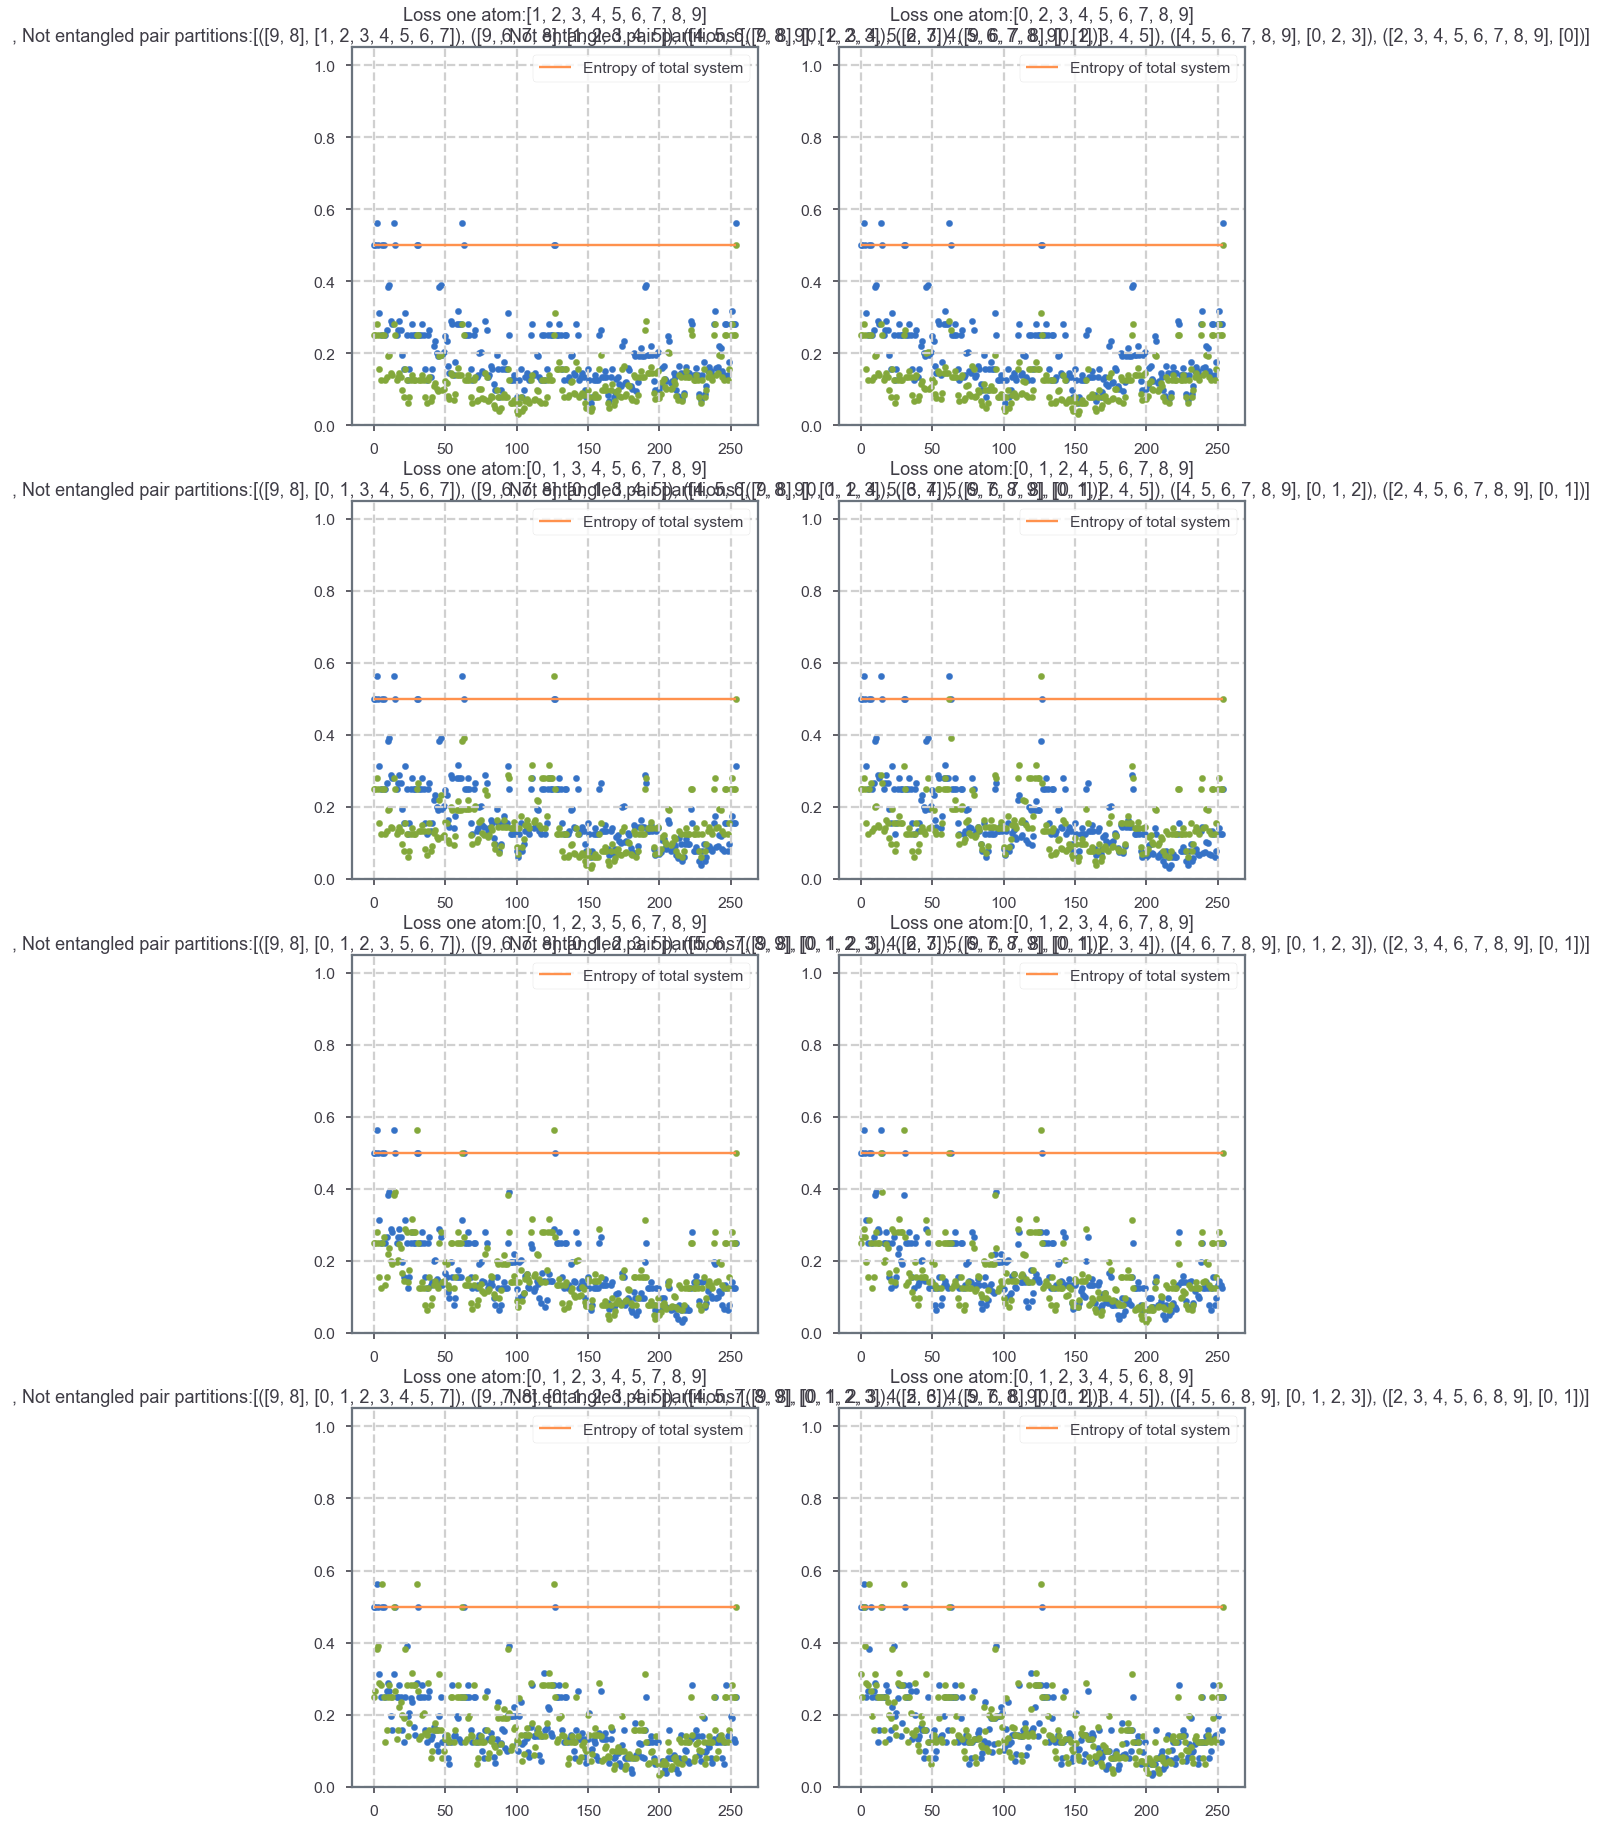

In [938]:
lossconfig=[]
for i in range(n):
    tmp=list(range(n))
    del (tmp[i])
    lossconfig.append(tmp)

print('All possible remain atoms config:',lossconfig)
allposloss0=splittosys(n-1)[0]
allposloss1=splittosys(n-1)[1]

finalstate=np.array(result2.states)[-1]
pltflag=1
plt.figure(figsize=(16,10*8))
for config in lossconfig: 
    finalentrpy0=[]
    finalentrpy1=[]
    lossstate=finalstate.ptrace(config)
    entropytotal=round(entropycheck(finalstate,config),5)
    unentangledpair=[]
    for i in range(len(allposloss0)):
        s0=list(allposloss0[i])
        s1=list(allposloss1[i])
        subentropy0=round(entropycheck(lossstate,s0),5)
        subentropy1=round(entropycheck(lossstate,s1),5)
        finalentrpy0.append(subentropy0)
        finalentrpy1.append(subentropy1)
        if subentropy0>entropytotal or subentropy1>entropytotal:
            #print(subentropy0,subentropy1)
            unentangledpair.append((list(np.array(config)[s0]),list(np.array(config)[s1])))
    plt.subplot(4,2,pltflag)
    pltflag+=1
    #plt.title('Purity of Subsystem')
    plt.ylim((0,1.05))
    plt.title('Loss one atom:'+str(config)+'\n , Not entangled pair partitions:'+str(unentangledpair))
    plt.hlines(entropytotal,0,len(allposloss0)-1,colors='y',label='Entropy of total system')
    plt.scatter(range(len(allposloss0)),finalentrpy0,s=40)
    plt.scatter(range(len(allposloss1)),finalentrpy1,s=40)
    plt.legend(loc='best')
    print([np.array(config)[list(i)] for i in allposloss0])
    print('Not entangled pair:',unentangledpair)

CPU times: user 49 s, sys: 2.47 s, total: 51.5 s
Wall time: 35.8 s


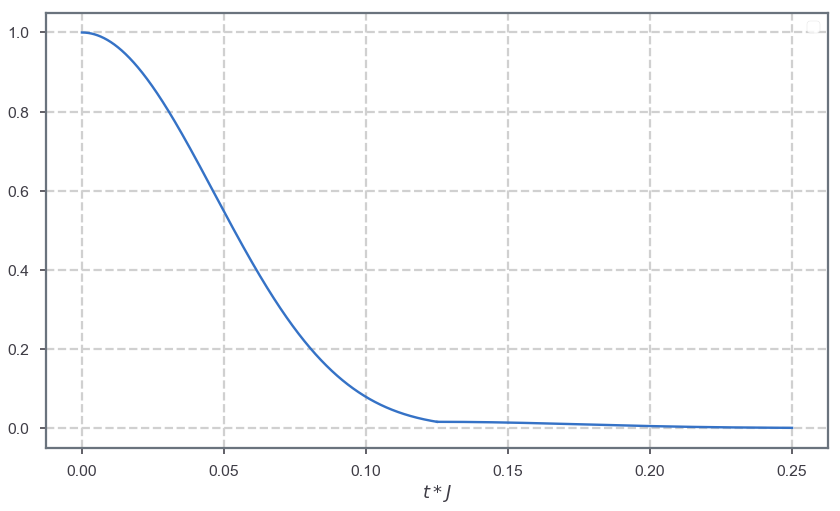

In [656]:
%%time
hamodd,hameven=genham(12,J)
initialstate=strtransferstate('101010101010')
#target=(strtransferstate('10101010')-strtransferstate('010101')-1j*strtransferstate('100110')-1j*strtransferstate('011001')).unit()
times=np.linspace(0,2*np.pi/J/8,5000)
result1=qutip.mesolve(hameven,initialstate,times,[],[])
result2=qutip.mesolve(hamodd,result1.states[-1],times,[],[])
plt.figure(figsize=(14,8))
plt.xlabel('$t*J$')
plt.plot(times*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result1.states),c='b')
plt.plot((times+times[-1])*J/2/np.pi,qutip.expect(qutip.ket2dm(initialstate),result2.states),c='b')
plt.legend(loc='best')
# plt.plot(times,qutip.expect(qutip.ket2dm(target),result1.states))
# plt.plot(times+times[-1],qutip.expect(qutip.ket2dm(target),result2.states))

[ 683  685  686  691  693  694  697  698  700  715  717  718  723  725
  726  729  730  732  739  741  742  745  746  748  753  754  756  811
  813  814  819  821  822  825  826  828  843  845  846  851  853  854
  857  858  860  867  869  870  873  874  876  881  882  884  907  909
  910  915  917  918  921  922  924  931  933  934  937  938  940  945
  946  948  963  965  966  969  970  972  977  978  980 1195 1197 1198
 1203 1205 1206 1209 1210 1212 1227 1229 1230 1235 1237 1238 1241 1242
 1244 1251 1253 1254 1257 1258 1260 1265 1266 1268 1323 1325 1326 1331
 1333 1334 1337 1338 1340 1355 1357 1358 1363 1365 1366 1369 1370 1372
 1379 1381 1382 1385 1386 1388 1393 1394 1396 1419 1421 1422 1427 1429
 1430 1433 1434 1436 1443 1445 1446 1449 1450 1452 1457 1458 1460 1475
 1477 1478 1481 1482 1484 1489 1490 1492 1579 1581 1582 1587 1589 1590
 1593 1594 1596 1611 1613 1614 1619 1621 1622 1625 1626 1628 1635 1637
 1638 1641 1642 1644 1649 1650 1652 1675 1677 1678 1683 1685 1686 1689
 1690 

<Container object of 486 artists>

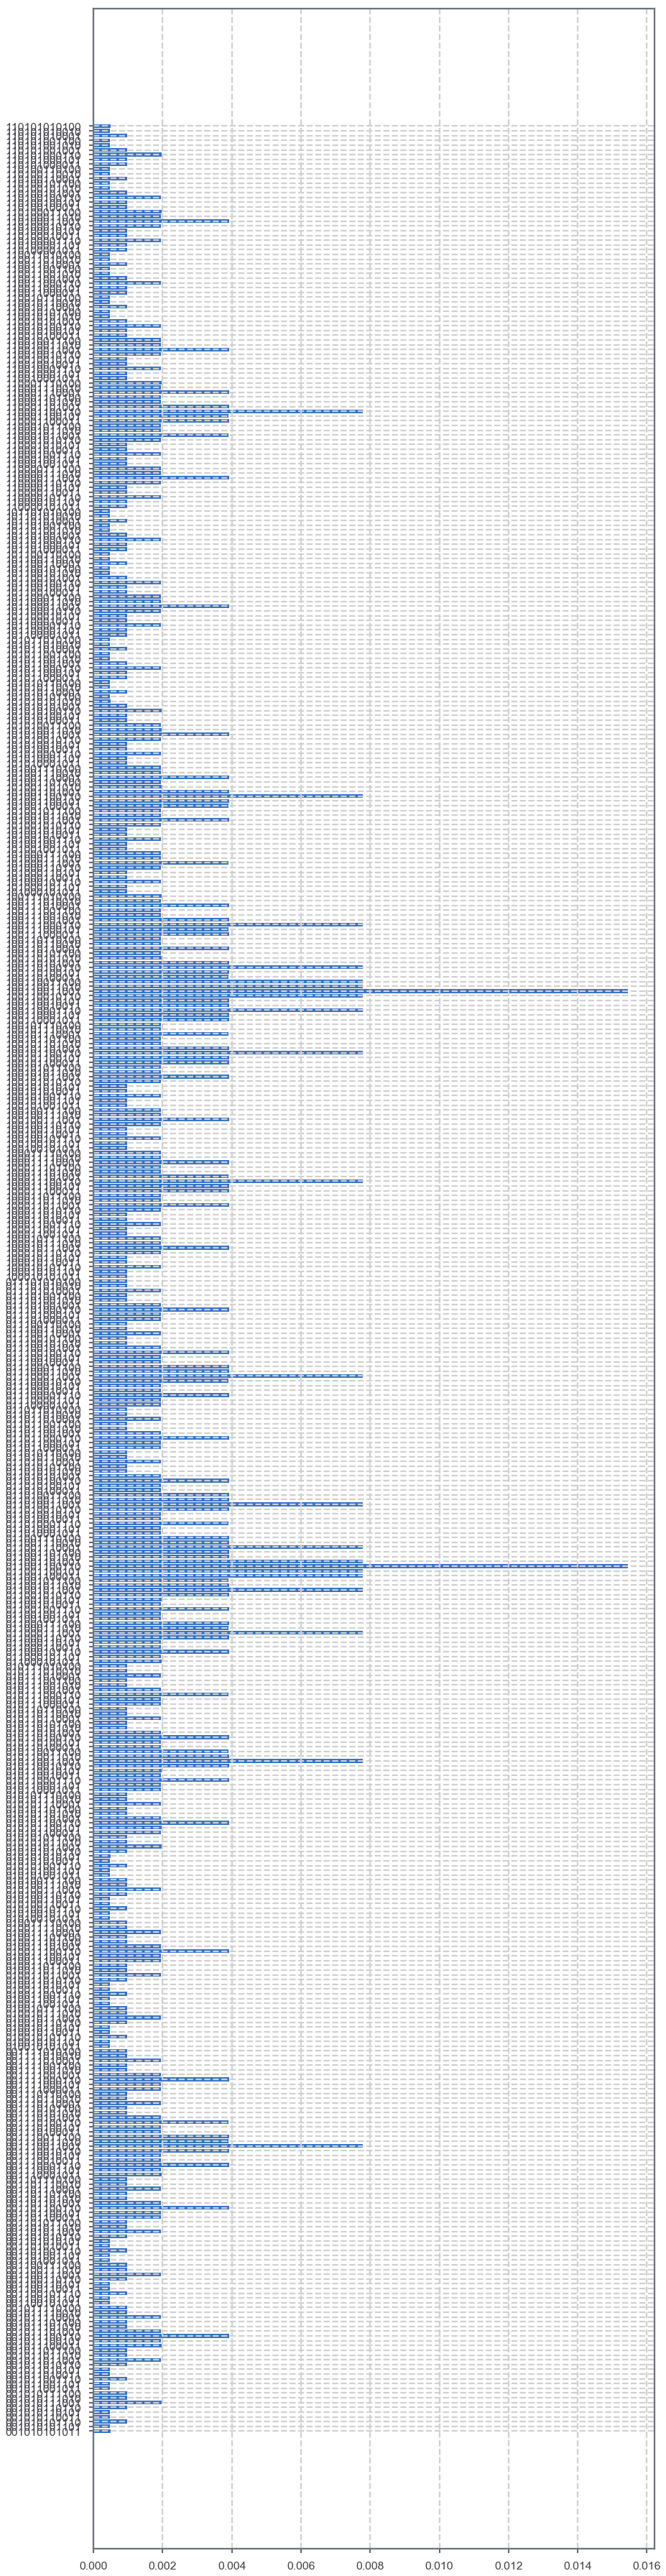

In [657]:
## for n=12 case
n=12
# b=list(permutations([1]*int(n/2)+[0]*int(n/2)))
# b=list(set(b))
# newb=[list(map(str,o)) for o in b]
# strb=[''.join(o) for o in newb]
indic=tsqtindtostate(n)
s=np.abs(result2.states[-1].full())**2
#print(s)
location=np.where(s!=0)
print(location[0])
print(indic[location[0]])
plt.figure(figsize=(14,65))
plt.barh(indic[location[0]],s[location])

KeyboardInterrupt: 

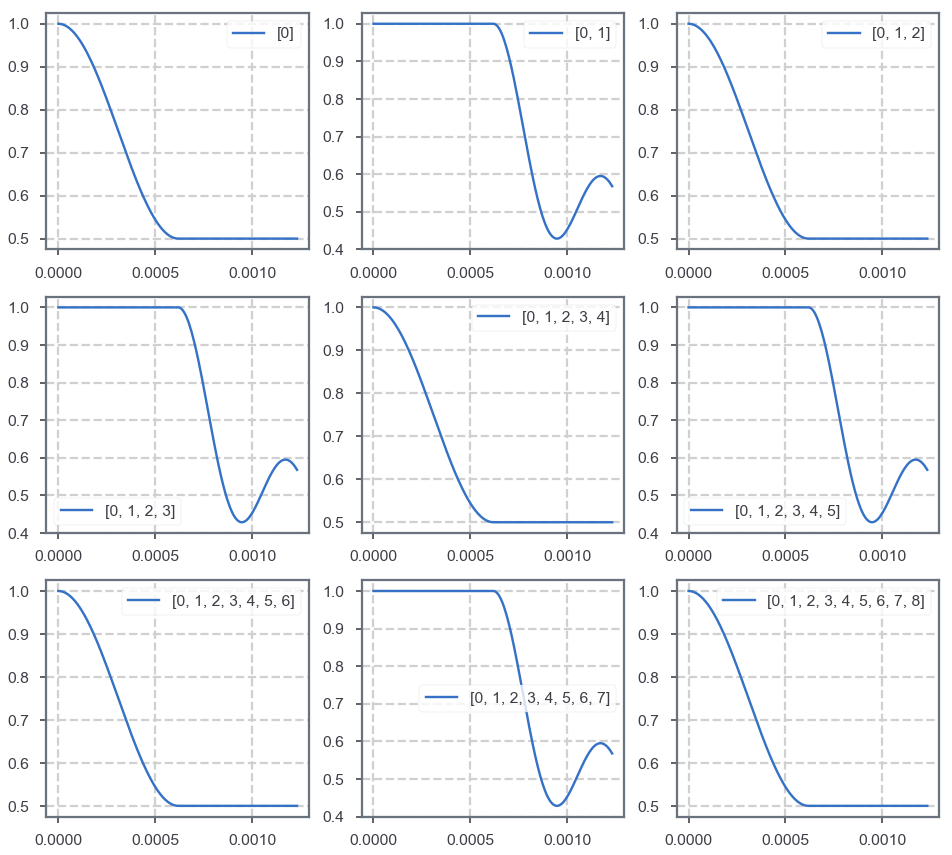

In [659]:
%%time
allpos=splittosys(12)[0]
subsystem1=list(allpos[-1])
subsystem2=list(allpos[2])
length=len(times)
ind=int(length/100)*np.arange(100)
statesin1=np.array(result1.states)[ind]
statesin2=np.array(result2.states)[ind]
statesin=np.append(statesin1,statesin2)
t2=np.append(times[ind],times[ind]+times[-1])
plt.figure(figsize=(16,20))
for i in range(1,n):
#     length=len(i)
# #     print()
#     st1=set(list(range(length)))
#     st2=set(list(range(6)))-st1
#     if i==st1 or i==st2:
        #print(i)
    sd=list(range(i))
    rho1=np.array([entropycheck(state,sd) for state in statesin])
    plt.subplot(4,3,i)
    plt.plot(t2,rho1,label=str(sd))
    plt.legend(loc='best')
    
finalstate=statesin[-1]
finalentrpy=[]
j=0
for i in allpos[:600]:
    print(j,end=' ')
    j+=1
    i=list(i)
    finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Purity of Subsystem')
plt.ylim((0,1))
plt.scatter(range(len(allpos)),finalentrpy,s=40)

CPU times: user 37.7 ms, sys: 5.71 ms, total: 43.4 ms
Wall time: 56.8 ms


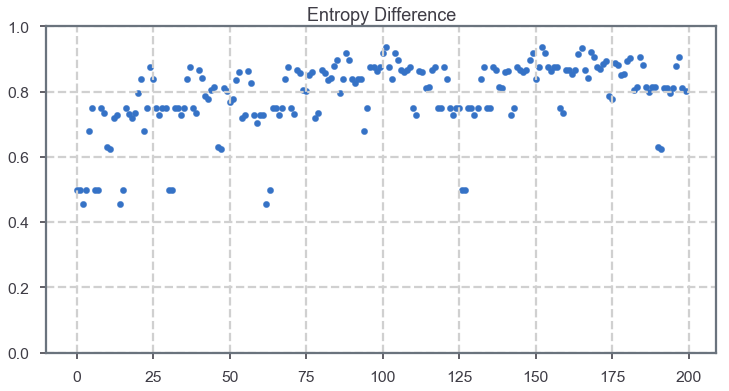

In [582]:
%%time
# finalstate=statesin[-1]
# finalentrpy=[]
# j=0
# for i in allpos[:200]:
#     print(j,end="")
#     j=j+1
#     i=list(i)
#     finalentrpy.append(entropycheck(finalstate,i))
plt.figure(figsize=(12,6))
plt.title('Entropy Difference')
plt.ylim((0,1))
plt.scatter(range(len(allpos[:200])),finalentrpy,s=40)

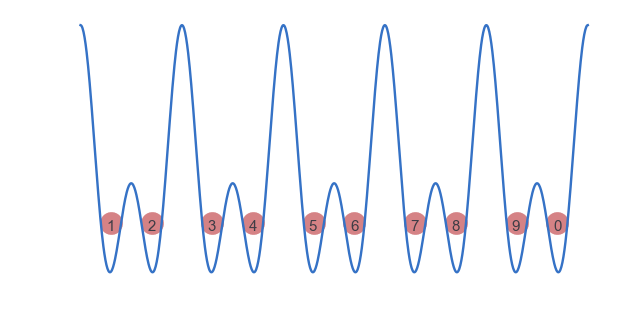

In [781]:
import matplotlib.patches as mpatches
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')
ellipse = mpatches.Ellipse([0.5,0.75], 0.8, 0.2, color= "y")

plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0.5*np.pi))**2)
ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500,alpha=0.7)
for i in range(5):
    ax.text(0.25+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.66+i,0.7,str((2*i+2)%10),fontsize=15)
#ax.add_patch(ellipse)
plt.savefig('1.pdf')

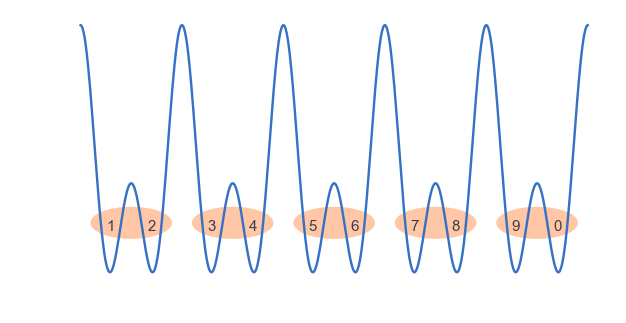

In [782]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0.5*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.25+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.66+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
plt.savefig('2.pdf')

In [783]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.17+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.76+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
plt.savefig('3.pdf')

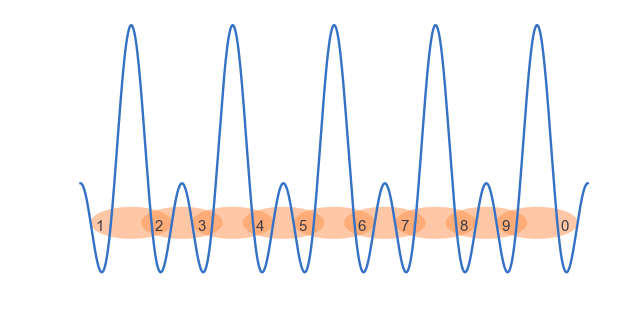

In [784]:
x=np.linspace(0,5,1000)
#y=np.linspace(0,5,1000)
fig,ax=plt.subplots(figsize=(10,5))
#fig.figure()
ax.grid('off')


plt.box('off')
plt.axis('off')
ax.plot(x,(np.cos(2*np.pi*x))**2+(np.sin(np.pi*x+0*np.pi))**2)
#ax.scatter([0.3+i for i in range(5)]+[0.7+i for i in range(5)],[0.75]*10,c='r',s=500)
for i in range(5):
    ax.text(0.15+i,0.7,str(2*i+1),fontsize=15)
    ax.text(0.73+i,0.7,str((2*i+2)%10),fontsize=15)
    ellipse = mpatches.Ellipse([0.5+i,0.75], 0.8, 0.2, color= "y",alpha=0.5)
    ax.add_patch(ellipse)
    if i!=4:
        ellipse = mpatches.Ellipse([1+i,0.75], 0.8, 0.2, color= 'y',alpha=0.5)
        ax.add_patch(ellipse)
plt.savefig('4.pdf')

In [850]:
splittosys(4)

([{3}, {2}, {2, 3}, {1}, {1, 3}, {1, 2}, {1, 2, 3}],
 [{0, 1, 2}, {0, 1, 3}, {0, 1}, {0, 2, 3}, {0, 2}, {0, 3}, {0}])

In [942]:
singleration(0.5*np.pi)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 6.123234e-17 -1.000000e+00]
 [ 1.000000e+00 -6.123234e-17]]

In [945]:
qutip.sigmaz()*qutip.sigmaz()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [949]:
qutip.qeye(2)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [950]:
list(range(1,n))

In [955]:
totalspinoperator(3)*totalspinoperator(3)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[9. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 9.]]

In [1087]:
qutip.basis(2,0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]